In [3]:
import pandas as pd
from database import select_dataset
import numpy as np

In [4]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna()
evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')

In [5]:
def pivot(df):
    return df.pivot(index=['ISO', 'Year'], columns='Variable', values='Value')

def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

In [6]:
def process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar):
    '''To cleanup !!! '''
    
    aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
    aquastat = aquastat[aquastat.Variable != 'CI']
    aquastat['Year'] = aquastat['Year'].astype(int)
    wb_data['Year'] = wb_data['Year'].astype(int)
    
    aquastat = fill_missing_values(pivot(aquastat))
    evapotranspiration = pivot(evapotranspiration)
    ETa = fill_missing_values(evapotranspiration['ETa'])
    ETo = evapotranspiration['ETo'].reset_index('Year', drop=True).dropna()
    cropcalendar = cropcalendar.pivot(index=['ISO', 'Item'], columns='Variable', values='Value')
    wb_data = pivot(wb_data)
    efficientwater = pivot(efficientwater)

    X = df_to_dict(aquastat)
    
    gva = df_to_dict(wb_data)
    ew = df_to_dict(efficientwater)
    
    X.update(gva)
    X.update(ew)
    
    X['ETa'] = ETa
    X['ETo'] = ETo
    X['LWU'] = 0
    X['KC'] = cropcalendar['Kc']
    X['ICA'] = cropcalendar['ICA']
    
    
    return X

In [7]:
data_dict = process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar)

# Model

In [8]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [9]:
for model_name, model in EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    print(score_model(model, X, y))

IWW_model : 
         r2  correlation         rmse Variable
0 -0.126651     0.937999   179.193726      IWR
1 -4.205210     0.418487  1603.099040      IWW
2 -0.062886     0.913503   575.215642      AWU
EW1_partial_model : 
         r2  correlation         rmse Variable
0  0.989945     0.994980     5.560493      TWW
1 -1.318223     0.491137  8018.101538      EW1
EW2_partial_model : 
         r2  correlation          rmse Variable
0  0.976665     0.990610  13890.813076      TFA
1 -0.111783     0.251153  54394.503560      EW2
EW1_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation         rmse Variable
0 -0.126651     0.937999   179.193726      IWR
1 -4.205210     0.418487  1603.099040      IWW
2 -0.062886     0.913503   575.215642      AWU
3  0.885780     0.945409     0.928600      MWU
4  0.185689     0.904184   648.592989      TWW
5  0.371841     0.670514  2356.053564      EW1
EW2_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation          rmse Variable
0 -0.126651     0.937999    179.193726      IWR
1 -4.205210     0.418487   1603.099040      IWW
2 -0.062886     0.913503    575.215642      AWU
3  0.885780     0.945409      0.928600      MWU
4  0.976665     0.990610  13890.813076      TFA
5 -0.111783     0.251153  54394.503560      EW2


# Test on model

In [42]:
WP = data_dict['WP']
GDPC = data_dict['GDPC']
Pop = data_dict['Pop']
MWU = data_dict['MWU']

scenario_df = pd.concat([WP, GDPC, Pop, MWU], axis=1).rename(columns={0: 'GDPC'}).reset_index()
ISO_scenario_df = scenario_df.query("ISO == 'FRA' and Year > 2005")\
                             .fillna(method='ffill')\
                             .fillna(method='bfill')

X = df_to_dict(ISO_scenario_df.set_index(['ISO', 'Year']))

In [43]:
# scenario_df = scenario_df[scenario_df.GDPC > 0].dropna()
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor

# reg = LinearRegression()
# y = scenario_df['MWU']
# X = scenario_df[['WP', 'GDPC', 'Pop']]
# cross_val_score(reg, X, y, cv=5)

In [44]:
MWU_comp = MWU_model.run(X)['MWU']

In [45]:
ISO_scenario_df['MWU_comp'] = MWU_comp.values

In [46]:
ISO_scenario_df

,ISO,Year,WP,GDPC,Pop,MWU,MWU_comp
4548,FRA,2006,2.18,40850.355530,63621381.0,5.683,7.989722
4549,FRA,2007,2.18,41582.799705,64016225.0,5.683,8.123610
4550,FRA,2008,2.18,41456.483420,64374984.0,5.683,8.153801
4551,FRA,2009,2.18,40058.679760,64707040.0,5.683,8.030574
4552,FRA,2010,2.18,40638.334004,65027507.0,5.683,8.138699
4553,FRA,2011,2.18,41329.035361,65342780.0,5.683,8.259585
4554,FRA,2012,2.18,41258.274731,65659809.0,5.380,8.290683
4555,FRA,2013,2.18,41282.990800,65998687.0,5.380,8.335825
4556,FRA,2014,2.18,41480.769608,66312067.0,5.380,8.398574
4557,FRA,2015,2.18,41793.544712,66548272.0,5.380,8.465626


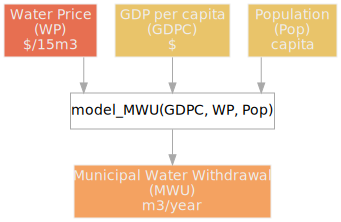

In [14]:
MWU_model.draw()

In [ ]:
aquastat.query("Variable == 'MWU'")